<a href="https://colab.research.google.com/github/NadyaPutriAmalia/PCVK_Ganjil_2023/blob/main/UAS_PCVK_Deteksi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UAS PCVK - Char Detection and Face Detection
Kelompok 10 <br>
- Nadya Putri Amalia
- Ibnu Hajar Askholani
- Zaky Muhammad Ibrahim

In [ ]:
import os
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load Data

In [ ]:
model = load_model('/content/gdrive/MyDrive/PCVK/ocr_custom/model.h5')
# check summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [ ]:
digits = '0123456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
char_list = digits + letters
char_list = [ch for ch in char_list]

# Download Haar Cascade Classifier untuk face detection
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml


--2023-12-17 06:57:42--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.1’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.01s   

2023-12-17 06:57:43 (79.3 MB/s) - ‘haarcascade_frontalface_default.xml.1’ saved [930127/930127]



## Panggil

In [ ]:
# def image_rgb(path):
#     # Konversi warna BGR ke RGB
#     image = cv2.imread(path)
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     return image_rgb

# Define function for contour detection
def find_contours(img):
  conts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  conts = imutils.grab_contours(conts)
  conts = sort_contours(conts, method='left-to-right')[0]

  return conts

# Redefine roi --> include margin
def extract_roi(img, margin=2):
  roi = img[y - margin:y+h, x - margin:x + w + margin]
  return roi

def thresholding(img):
  thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  print(thresh)
  return thresh

def resize_img(img, w, h):
  if w > h:
    resized = imutils.resize(img, width=28)
  else:
    resized = imutils.resize(img, height=28)

  # (w, h) = resized.shape
  (h, w) = resized.shape

  # Calculate how many pixels need to fill char image
  dX = int(max(0, 28 - w) / 2.0)
  dY = int(max(0, 28 - h) / 2.0)

  filled = cv2.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))
  filled = cv2.resize(filled, (28,28))

  return filled

def normalization(img):
  img = img.astype('float32') / 255.0 # convert to floating point
  img = np.expand_dims(img, axis=-1) # add depth
  return img



In [ ]:
def predict(image, nt, kr1, kr2):
  # Preprocess
  nilai = nt
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  enhanced_image = cv2.equalizeHist(gray)
  _, thresholded = cv2.threshold(enhanced_image, nilai, 255, cv2.THRESH_BINARY)

  kernel = np.ones((kr1, kr2), np.uint8)
  erode = cv2.morphologyEx(thresholded, cv2.MORPH_ERODE, kernel)
  invertion = 255 - erode
  cv2_imshow(invertion)

  # Load Haar Cascade Classifier untuk face detection
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  # Deteksi wajah menggunakan Haar Cascade Classifier
  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
      face_roi = gray[y:y+h, x:x+w]

  # Mulai Deteksi Karakter
  conts = find_contours(invertion.copy())

  min_w, max_w = 10, 180
  min_h, max_h = 14, 180
  img_copy = image.copy() # original image for plotting countour result
  filtered_conts = []
  detected_char = []

  for c in conts:
    (x, y, w, h) = cv2.boundingRect(c) # find bounding box based on contour
    if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h): # if pixel follow this rule, it consider as char
      filtered_conts.append(c)
      roi = gray[y:y+h, x:x+w] # get region of interest for char
      thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
      # cv2_imshow(thresh) # check

      # Build bounding box on original image
      cv2.rectangle(img_copy, (x,y), (x+w, y+h), (255,0,0), 2)
      (h, w) = thresh.shape
      resized = resize_img(thresh, w, h)
      normalized = normalization(resized)
      detected_char.append((normalized, (x, y, w, h)))


  pixels = np.array([px[0] for px in detected_char], dtype='float32')

  # Get all box for detected char
  boxes = [box[1] for box in detected_char]

  # Predict
  preds = model.predict(pixels)

  # Char Prediction
  for p in preds:
    char_idx = np.argmax(p)

  # Show char with actual image
  img_copy2 = image.copy()

  for(pred, (x, y, w, h)) in zip(preds, boxes):
    i = np.argmax(pred)
    char_detected = char_list[i]

    cv2.rectangle(img_copy2, (x, y), (x+w, y+h), (255,0,0), 2)
    cv2.putText(img_copy2, char_detected, (x - 10, y - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

  return img_copy2

In [ ]:
gambar = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720191_1 - ali murrofid.jpg')
cv2_imshow(predict(gambar, 115, 1, 1))

## Lain

In [ ]:
data_path = '/content/gdrive/MyDrive/PCVK/Kelompok 10'
file_list = os.listdir(data_path)

# Tampilkan beberapa file gambar sebagai contoh
file_list[:15]

['3E_2141720226_5 - Fawwaz Firzananda.jpg',
 '3E_2141720191_1 - ali murrofid.jpg',
 '3E_2141720244_5 - M. Rafy Shah Pahlevi.jpg',
 '3E_2141720244_3 - M. Rafy Shah Pahlevi.jpg',
 '3E_2141720226_2 - Fawwaz Firzananda.jpg',
 '3E_2141720244_2 - M. Rafy Shah Pahlevi.jpg',
 '3E_2141720244_1 - M. Rafy Shah Pahlevi.jpg',
 '3E_2141720226_4 - Fawwaz Firzananda.jpg',
 '3E_2141720191_4 - ali murrofid.jpg',
 '3E_2141720244_4 - M. Rafy Shah Pahlevi.jpg',
 '3E_2141720191_3 - ali murrofid.jpg',
 '3E_2141720191_5 - ali murrofid.jpg',
 '3E_2141720226_1 - Fawwaz Firzananda.jpg',
 '3E_2141720226_3 - Fawwaz Firzananda.jpg',
 '3E_2141720191_2 - ali murrofid.jpg']

### Ropid

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720191_1 - ali murrofid.jpg')
cv2_imshow(predict(burik, 130, 1, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720191_2 - ali murrofid.jpg')
cv2_imshow(predict(burik, 135, 1, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720191_3 - ali murrofid.jpg')
burik2 = cv2.rotate(burik, cv2.ROTATE_90_CLOCKWISE)
cv2_imshow(predict(burik2, 129, 1, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720191_4 - ali murrofid.jpg')
burik2 = cv2.rotate(burik, cv2.ROTATE_90_CLOCKWISE)
cv2_imshow(predict(burik2, 125, 1, 1))

### Paw

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720226_1 - Fawwaz Firzananda.jpg')
cv2_imshow(predict(burik, 50, 2, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720226_3 - Fawwaz Firzananda.jpg')
cv2_imshow(predict(burik, 50, 1, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720226_5 - Fawwaz Firzananda.jpg')
cv2_imshow(predict(burik, 83, 2, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720226_2 - Fawwaz Firzananda.jpg')
cv2_imshow(predict(burik, 56, 1, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720226_4 - Fawwaz Firzananda.jpg')
cv2_imshow(predict(burik, 118, 1, 1))

### Rafy

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720244_1 - M. Rafy Shah Pahlevi.jpg')
cv2_imshow(predict(burik, 100, 2, 2))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720244_2 - M. Rafy Shah Pahlevi.jpg')
cv2_imshow(predict(burik, 113, 3, 3))

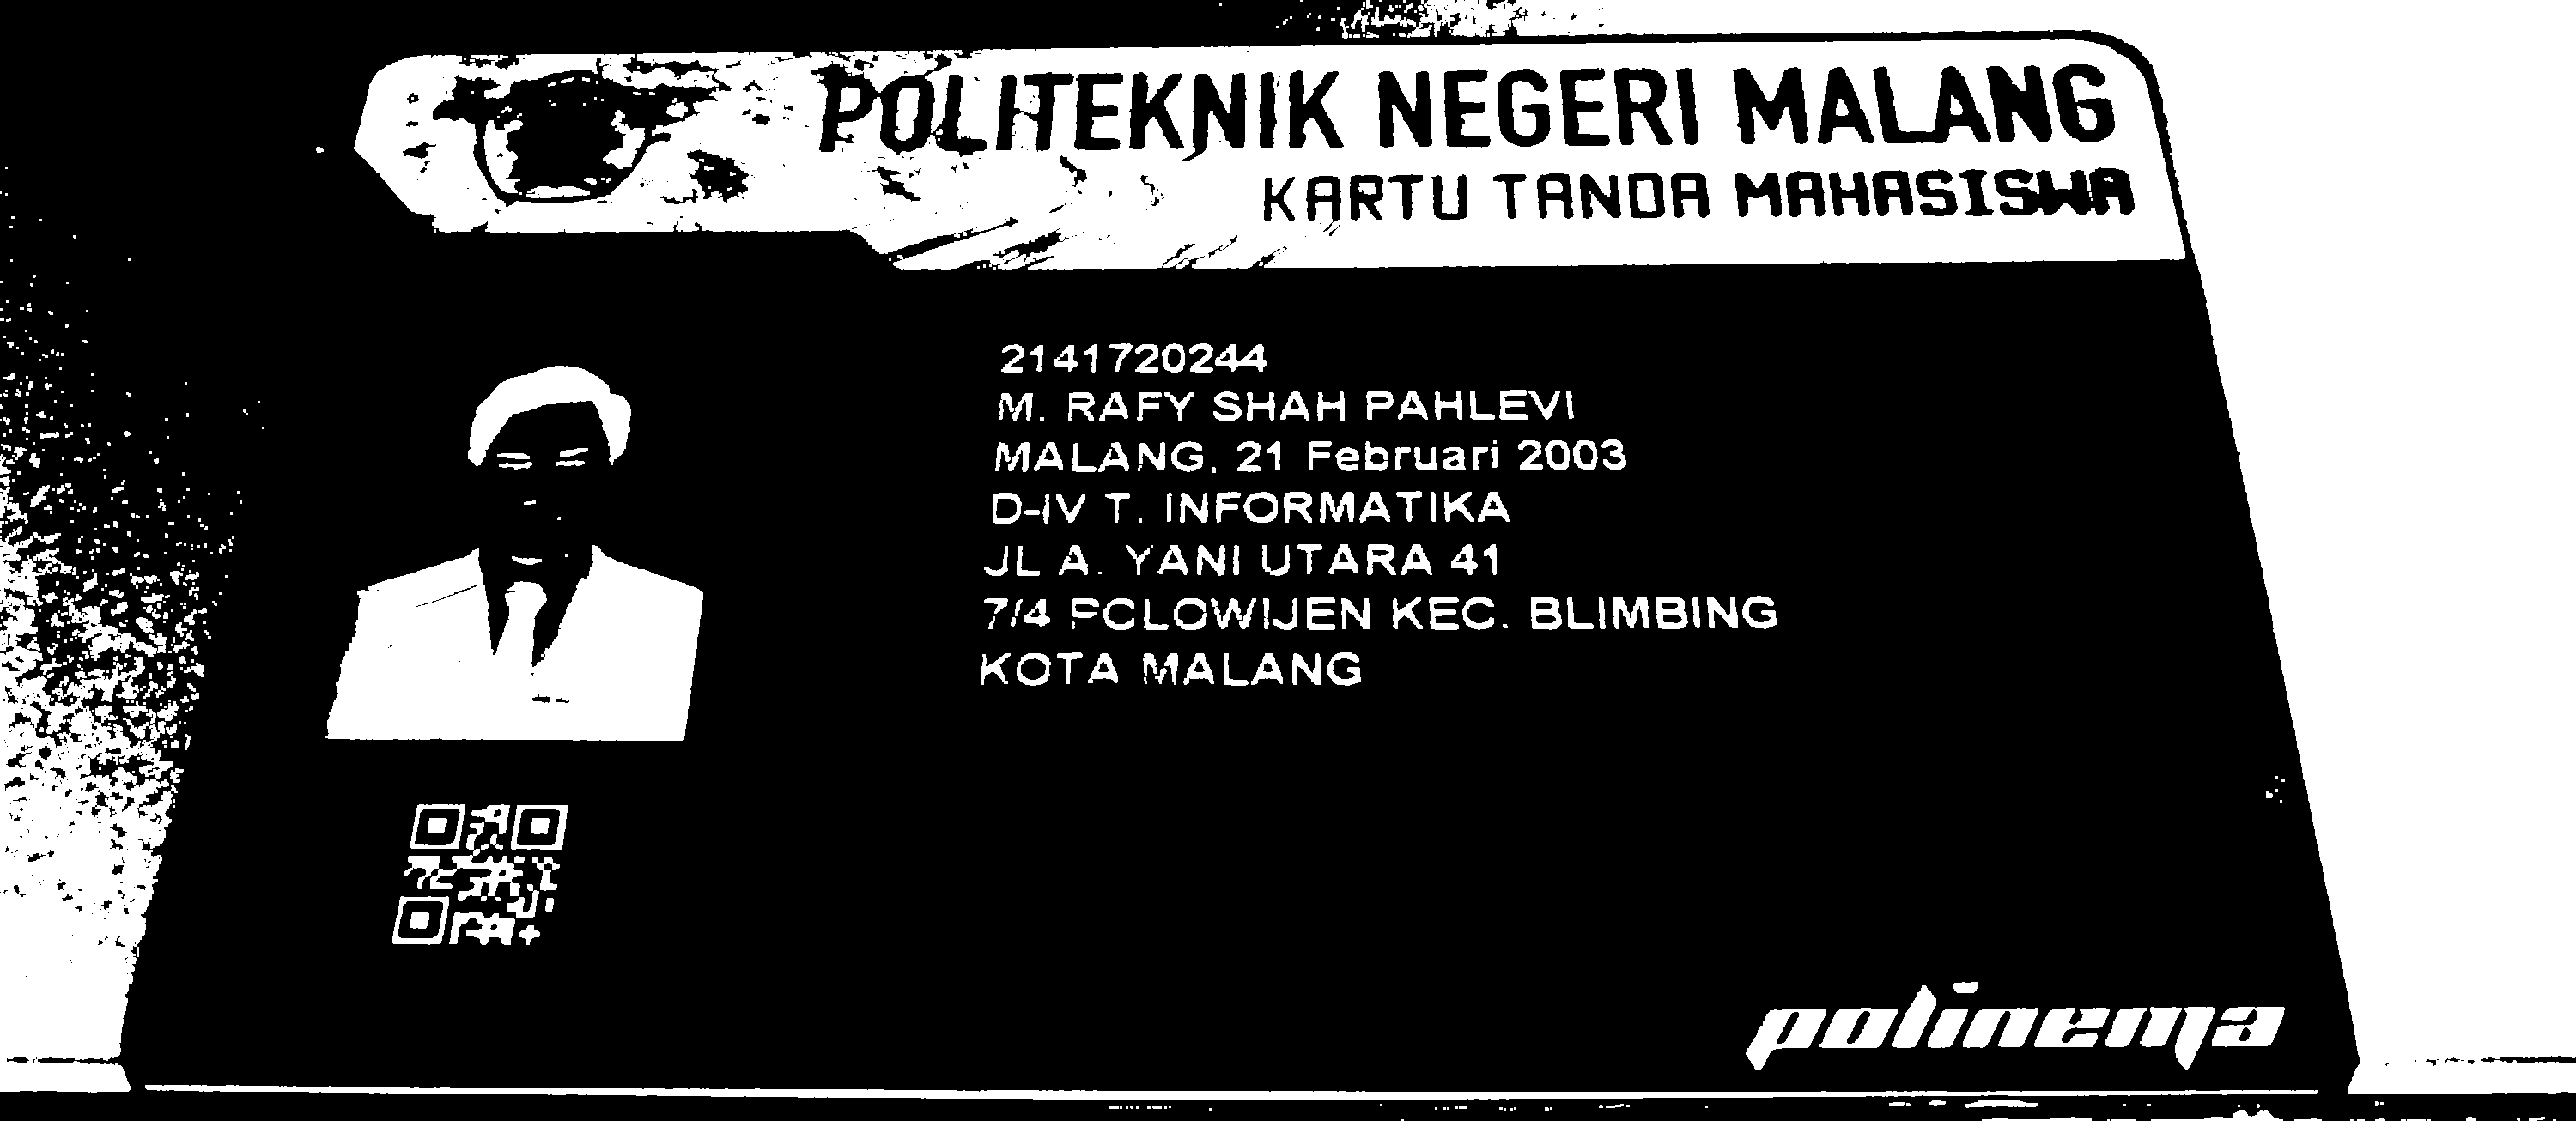

5/5 [==============================] - 0s 16ms/step


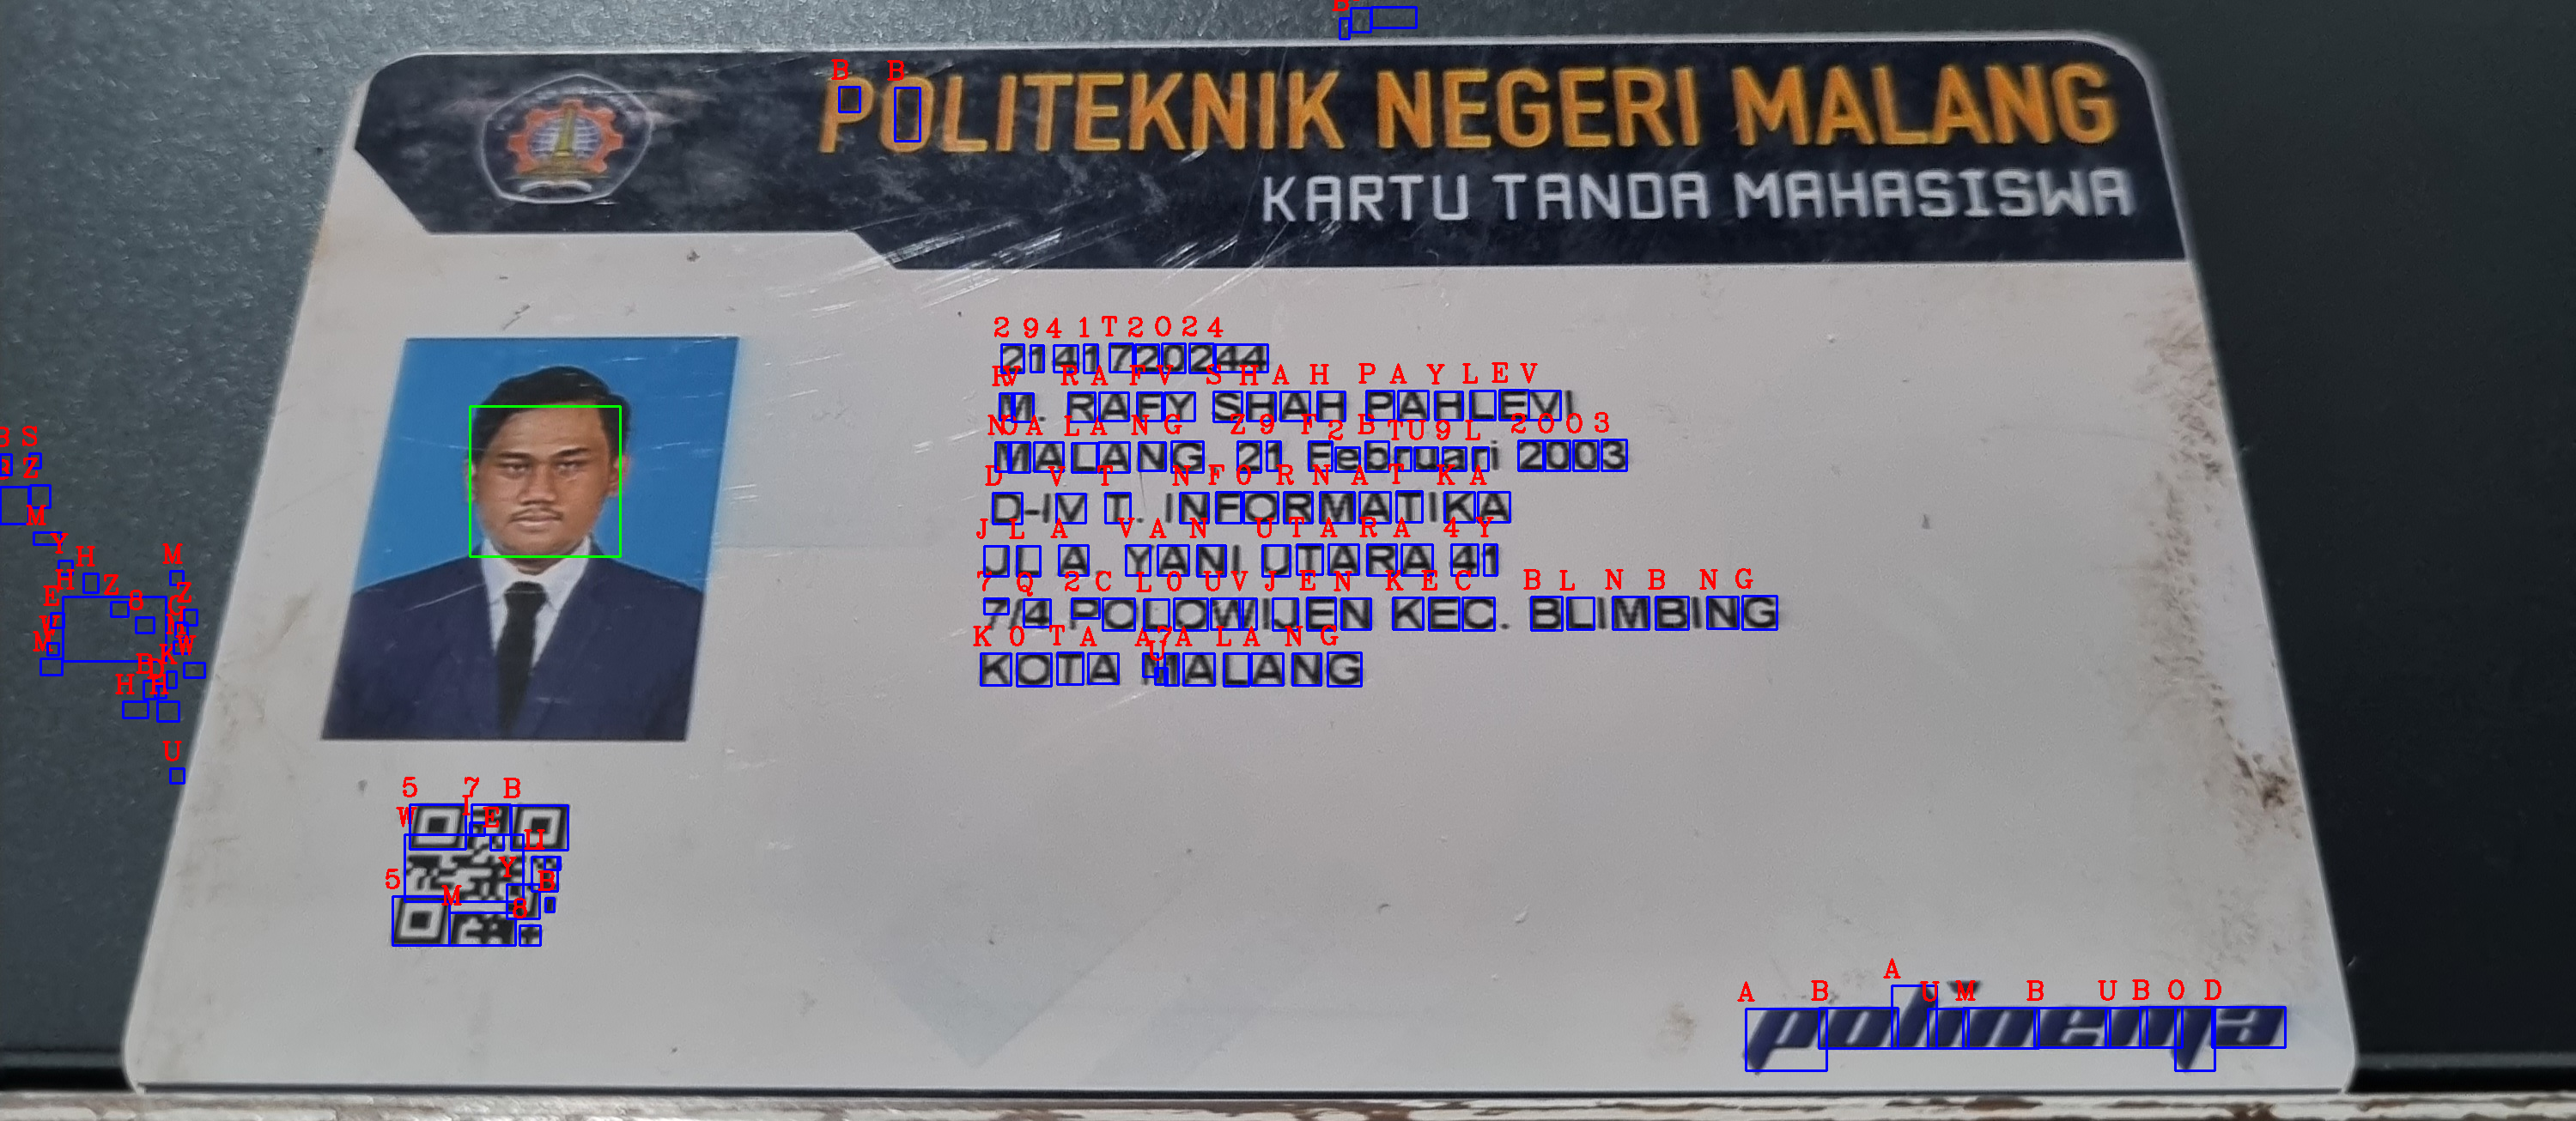

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720244_3 - M. Rafy Shah Pahlevi.jpg')
cv2_imshow(predict(burik, 70, 3, 3))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720244_4 - M. Rafy Shah Pahlevi.jpg')
cv2_imshow(predict(burik, 123, 1, 1))

In [ ]:
burik = cv2.imread('/content/gdrive/MyDrive/PCVK/Kelompok 10/3E_2141720244_5 - M. Rafy Shah Pahlevi.jpg')
cv2_imshow(predict(burik, 113, 1, 1))

### Bulk 115, 1, 1

In [ ]:
import os
from google.colab.patches import cv2_imshow

# Path ke folder yang berisi gambar
data_path = '/content/gdrive/MyDrive/PCVK/Kelompok 10'

# Ambil daftar nama file gambar
image_files = [file for file in os.listdir(data_path) if file.endswith(('.jpg', '.jpeg', '.png'))]

# Loop melalui setiap file gambar
for image_file in image_files:
    # Buat path lengkap ke gambar
    image_path = os.path.join(data_path, image_file)

    # Baca gambar
    image = cv2.imread(image_path)

    # Jika gambar berhasil dibaca
    if image is not None:
        # Tampilkan nama file
        print("Processing:", image_file)

        # Rotasi gambar jika nama file memenuhi kondisi
        if '3E_2141720191_3 - ali murrofid.jpg' in image_file or '3E_2141720191_4 - ali murrofid.jpg' in image_file:
            image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)

        # Lakukan prediksi dan tampilkan hasil
        result_image = predict(image)
        cv2_imshow(result_image)

    else:
        print("Failed to read:", image_file)
